<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw7/nn_hw7_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## _[NN HW7](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/05-nlp/02-fasttext/HomeWork.ipynb "NN HW7") -- baseline_

Необходимо обучить регрессионную модель (предсказание популярности статьи на Хабре) - за бейзлайн возьмите tf-idf + линейная модель:

train - https://yadi.sk/d/hAhCuetI3JPouk

test - https://yadi.sk/d/mLMZZtN63JPouc

---

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls -hAlF *.csv

-rw------- 1 root root 107M May 10 15:56 test_content.csv
-rw------- 1 root root 1.8G May 10 15:58 train_content.csv


## 1. _Данные_

In [0]:
train_content = pd.read_csv('train_content.csv')
test_content = pd.read_csv('test_content.csv')

In [5]:
train_content.shape

(172913, 13)

In [6]:
train_content.head(3)

,_id,date,tags,title,hubs_title,description,name,hub,png,nick,url,content,favs_lognorm
0,https://geektimes.ru/post/21866/,2008-03-17T18:55:00.000Z,"['eeepc', 'asus', 'ЭТО', 'эльдорадо', 'ура']",eeePC в продаже. Да. Правда.,Железо,"Итак, если 3 дня назад я отписался то что в пр...",Сергей 'pokatusher',hub/hardware,https://habrastorage.org/getpro/habr/olpicture...,@M_org,https://geektimes.ru/users/M_org,"Итак, если 3 дня назад я <a href=""http://habra...",2.484907
1,https://habrahabr.ru/company/aladdinrd/blog/30...,2016-06-24T13:02:00.000Z,"['Интеграция', 'шифрование', 'Windows', 'Win32...",«Разрубить Гордиев узел» или преодоление пробл...,Системное программирование,Современная операционная система это сложный и...,Аладдин Р.Д.,hub/system_programming,https://habrastorage.org/files/cbd/cf9/5ff/cbd...,NaN,https://habrahabr.ru/company/aladdinrd,Современная операционная система это сложный и...,4.174387
2,https://geektimes.ru/post/92887/,2010-05-06T10:00:00.000Z,"['mc', 'midnight commander', 'diffview', 'merg...",Релиз Midnight Commander 4.7.2 и 4.7.0.5,Чёрная дыра,Спустя 2 месяца упорных трудов вышла новая вер...,Илья Маслаков,hub/closet,https://geektimes.ru/images/logo.png,@smind,https://geektimes.ru/users/smind,Спустя 2 месяца упорных трудов вышла новая вер...,0.000000


In [7]:
train_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172913 entries, 0 to 172912
Data columns (total 13 columns):
_id             172913 non-null object
date            172913 non-null object
tags            172913 non-null object
title           172913 non-null object
hubs_title      172913 non-null object
description     172299 non-null object
name            143259 non-null object
hub             172913 non-null object
png             172913 non-null object
nick            135210 non-null object
url             172913 non-null object
content         172861 non-null object
favs_lognorm    172913 non-null float64
dtypes: float64(1), object(12)
memory usage: 17.1+ MB


In [8]:
train_content.describe(exclude=np.number).T

,count,unique,top,freq
_id,172913,172913,https://habrahabr.ru/post/80721/,1
date,172913,167976,2011-06-14T15:52:00.000Z,39
tags,172913,161419,[],1251
title,172913,171859,"Интересные события, произошедшие в выходные",56
hubs_title,172913,1709,Чёрная дыра,30205
description,172299,168898,,2036
name,143259,16140,Анатолий Ализар,7186
hub,172913,1702,hub/closet,30206
png,172913,109236,https://habrahabr.ru/i/habralogo.jpg,31516
nick,135210,26670,@alizar,7186


In [9]:
train_content.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
favs_lognorm,172913.0,2.802295,1.71161,0.0,1.386294,2.890372,4.110874,9.080687


Распределение по текстов по длине:

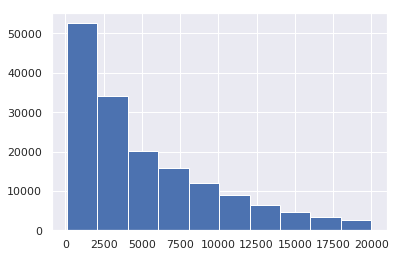

In [10]:
plt.hist(train_content['content'][train_content['content'].notnull()].str.len(), range=(100, 20000));

В данных из `test_content.csv` нет целевой переменной (видимо, это тестовый сет с соревнования), поэтому в данном случае его использовать невозможно.

In [11]:
test_content.shape

(5405, 12)

Так что будем оценивать MSE по кросс-валидации на датасете `train_content.csv`.

## 2. _Модель_

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor

Отбросим пустые и совсем короткие тексты. Объединим заголовок и текст статьи. Одновременно сделаем перемешивание.

In [0]:
def select_content_favs(d, min_len=100, size=1.):
    w = (d['content'].notnull()) & (min_len < d['content'].str.len())
    i = np.argwhere(w).squeeze()
    i = i[np.random.choice(len(i), size=int(len(i) * size), replace=False)]
    return ((d['title'][i] + ' ' + d['content'][i]).values, d['favs_lognorm'][i].values)

In [14]:
X_train_text, y_train = select_content_favs(train_content)

del train_content, test_content

[ x.shape for x in (X_train_text, y_train) ]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


[(170211,), (170211,)]

In [15]:
[ s[:100] for s in X_train_text[:3] ]

['Интервью с разработчиком iPhone-приложений Константин Павлихин, разработчик из <a href="http://deepi',
 'Прошивка iPhone 2.0 взломана и разлочена <img src="https://habrastorage.org/getpro/habr/olpictures/3',
 'Как, когда и о чем говорить с посетителем вашего сайта для увеличения конверсии? <img src="https://h']

В силу ограничения по памяти прямое применение [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html "sklearn.feature_extraction.text.CountVectorizer") ко всему корпусу текстов оказалось невозможным (в том числе даже на [**google colab**](https://colab.research.google.com/notebooks/welcome.ipynb "Welcome to Colaboratory!")). Можно было бы пытаться регулировать размер используемой RAM с помощью таких параметров, как `max_df`, `min_df` и `max_features`, но всё-таки хотелось бы как-то осмысленно выбирать их значения.

В итоге я решил использовать [hashing trick](https://scikit-learn.org/stable/modules/feature_extraction.html#hashing-vectorizer "Vectorizing a large text corpus with the hashing trick") и [`HashingVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html "sklearn.feature_extraction.text.HashingVectorizer") (он не хранит словарь). 

_**TODO**_: возможно, имело бы смысл посмотреть в сторону [h5py](http://docs.h5py.org/en/stable "HDF5 for Python") и [линейных моделей **sklearn**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model "sklearn.linear_model"), поддерживающих [online learning](https://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html#sphx-glr-auto-examples-applications-plot-out-of-core-classification-py "Out-of-core classification of text documents") (метод  [`partial_fit`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor.partial_fit "sklearn.linear_model.SGDRegressor")), но это немного out of scope для текущей задачи.

In [16]:
hv = HashingVectorizer(ngram_range=(1, 1), n_features=2**20, norm=None)

X_train_hv = hv.fit_transform(X_train_text)

del X_train_text

X_train_hv

<170211x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 72572508 stored elements in Compressed Sparse Row format>

Стандартная регрессионная модель [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html "sklearn.linear_model.LinearRegression") очень долго обучается на матрице такого размера, поэтому я решил использовать линейную модель, минимизирующую функцию потерь с помощью [SGD](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html "sklearn.linear_model.SGDRegressor").

In [17]:
pipeline = make_pipeline(TfidfTransformer(norm='l2'),
                         SGDRegressor(penalty='elasticnet', shuffle=False, tol=1e-3, n_iter_no_change=5, verbose=0))

lr_scores = cross_val_score(pipeline, X_train_hv, y_train, scoring='neg_mean_squared_error', 
                            cv=5, verbose=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.6min finished


### Baseline score:

In [18]:
print(lr_scores)

print(f'{np.mean(-1*lr_scores):.4f}')

[-1.34440117 -1.3644654  -1.3661725  -1.34364036 -1.3662467 ]
1.3570
